# Wstęp

Celem projektu jest przeprowadzenie segmentacji semantycznej obrazów. W zadaniu tym należy zaklasyfikować każdy piksel obrazu na podstawie obiektu, do którego on należy. Korzystam ze zbioru [Pascal VOC](host.robots.ox.ac.uk/pascal/VOC/).

# Struktura projektu

Role poszczególnych katalogów są następujące:
* katalog `base` zawiera klasy bazowe dla modeli, preorocessingu i trenerów.
* katalog `models` zawiera poszczególne klasy modeli. Klasy te powinny dziedziczyć po klasie `BaseModel`.
* katalog `data_preprocessing` zawiera klasy implementujące wstępne przetwarzanie danych. Te klasy powinny dziedziczyć po klasie `BaseDataPreprocessing`.
* katalog `trainers` zawiera klasy trenerów. Powinny one dziedziczyć po klasie `BaseTrainer`.
* katalog `configs` zawiera pliki konfiguracyjne.
* katalog `scripts` zawiera dodatkowe skrypty.

## Konfiguracja

W projekcie wykorzystywałem pliki konfiguracyjne w formacie YAML. Pliki te podzielone są na następujące sekcje:
* `devices` zawiera ustawienia związane z urządzeniami GPU
* `data` zawiera ustawienia związane z wczytywaniem danych
* `data_preprocessing` zawiera ustawienia związane ze wstępnym przetwarzaniem danych
* `model` wskazuje klasę modelu oraz wszystkie potrzebne jej ustawienia (np. wymiary warstw, dropout, learning rate)
* `trainer` wskazuje klasę trenera oraz wszystkie potrzebne jej ustawienia (np. liczbę epok)

Dokładniejszy opis poszczególnych parametrów znajduje się w pliku `configs/base_config.yml`

## Pobieranie danych

Dane można pobrać za pomocą skryptu `scripta/downloads.sh`. Domyślną lokalizacją jest katalog `data`.

## Wczytywanie danych

Dane wczytywane są z rozpakowanego katalogu ze zdjęciami. Obrazy zapisane są w formacie JPG, a adnotacje w formacie PNG. Kolory w plikach z adnotacjami zamieniane są na identyfikatory klas zgodnie ze specyfikacją podaną przez autoróœ zbioru.

Dostarczany zbiór danych jest podzielony na część treningową, walidacyjną i testową. Ponieważ jednak część testowa nie posiada dostępnych adnotacji, stosuję własny podział w którym połączone części uczącą i walidacyjną dzielę w proporcjach 70%-15%-15%.

## Przetwarzanie danych

Wczytane dane są normalizowane tak, aby każdy piksel miał w przybliżeniu średnią 0 i wariancję 1. Normalizacja ta jest zgodna ze wszystkimi stosowanymi przeze mnie gotowymi modelami.

Również na tym etapie przeprowadzana jest augmentacja danych. Stosuję następujące operacje:
* Odbicie poziome obrazu i maski, z prawdopodobieństwem $0.5$.
* Niewielka zmiana odcieni
* Zmiana nasycenia barw obrazu
* Zmiana jasności obrazu
* Zmiana kontrastu obrazu

Operacje te są istotne ze względu na niewielki rozmiar zbioru uczącego (ok. 2000 próbek).

Dodatkowo, ze względu na ograniczenia biblioteki Keras, na tym etapie obliczane są wagi poszczególnych pikseli podczas obliczania metryk.

## Przykładowe dane

In [1]:
from utils import config, data
import tensorflow as tf
import matplotlib.pyplot as plt
from data_preprocessing import resize
from itertools import islice

cfg = config.get_config("configs/report.yml")
preprocessing = resize.ResizePreprocessing(cfg)
preprocessing.preprocess_config()
train_loader = data.get_train_valid_data(cfg, preprocessing)["train"]

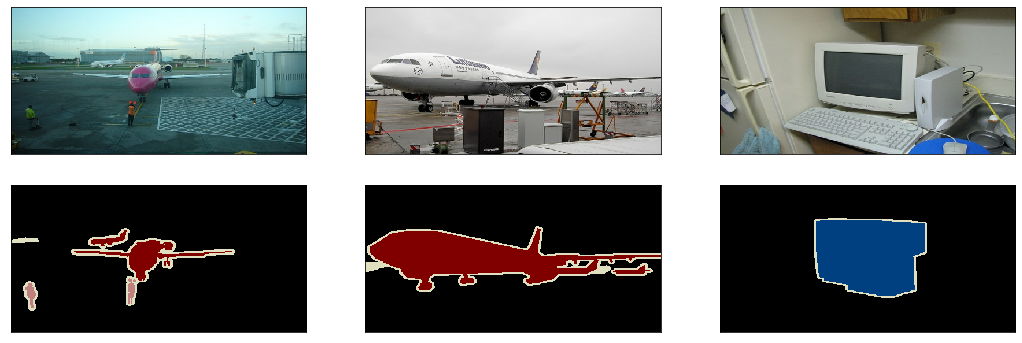

In [2]:
samples = iter(train_loader)

fig, axes = plt.subplots(figsize=(18, 6), ncols=3, nrows=2, facecolor="white")
for i, sample in enumerate(islice(samples, 3)):
    x, y, _weights = sample
    axes[0][i].imshow(x[0, :, :, :] / 255.)
    axes[0][i].set_xticks([])
    axes[0][i].set_yticks([])
    
    # ze względu na ograniczenia biblioteki Keras maski są reprezentowane przez wektory jednowymiarowe
    y = tf.reshape(y, (x.shape[1], x.shape[2], 22))
    y = tf.argmax(y, 2)
    y = data.indices_to_cmap(y)
    axes[1][i].imshow(y)
    axes[1][i].set_xticks([])
    axes[1][i].set_yticks([])

## Konstrukcja modeli

Aby zdefiniować nowy model należy utworzyć plik zawierający klasę dziedziczącą po klasie `BaseModel` oraz nadpisującą metodę `build_model`.

## Trenowanie modeli

Do trenowania modeli służą klasy trenerów. Klasa `BaseTrainer`, realizuje trenowanie z ustalonym parametrem learning rate oraz logowanie do tensorboard. Jest to też klasa bazowa dla pozostałych implementacji trenerów. W celu rozszerzenia funkcjonalności należy skorzystać z funkcji oferowanych przez moduł `keras.callbacks`, nadpisując metodę `init_callbacks` klasy `BaseTrainer`.

## Metryki

Ze względu na fakt, że klasa reprezentująca tło występuje znacznie częściej niż pozostałe klasy, zwykła metryka accuracy nie reprezentuje dobrze jakości modelu. Zamiast niej stosuję metrykę, która liczy średnią ważoną, w której klasa reprezentująca tło ma niższą wagę. W ten sam sposób ważona jest funkcja kosztu. Również na tym etapie wprowadzone jest ignorowanie dokładności dla pikseli leżących na brzegu obiektów (reprezentowane kolorem białym), zgodnie ze specyfikacją zadania.

# Zaimplementowane klasy

## Modele

### `UNetModel`

Model korzystający z architektury U-Net. Trenowane są zarówno część kodująca jak i dekodująca. Rozmiar sieci oraz liczba kanałów w poszczególnych warstwach ustalane są w pliku konfiguracyjnym. Jako regularyzację stosuję technikę Batch Normalization, podobnie jak w oryginalnej architekturze.

### `UnetMobileNetV2Model` oraz `UnetResNet50V2Model`

Modele te korzystają z architektury U-Net. Część dekodująca pozostaje bez zmian w stosunku do klasy `UNetModel`, w części kodującej stosowane są gotowe modele dostępne w module `keras.applications` - odpowienio `MobileNetV2` oraz `ResNet50V2`. Trenowana jest wyłącznie część dekodująca.

## Klasy trenujące

### `BaseTrainer`

Implementuje podstawowe funkcjonalności, tj. wywoływanie metody `model.fit`, logowanie do Tensorboard oraz opcjonalne zapisywanie najlepszego modelu po każdej epoce.

### `ReduceLROnPlateauTrainer`

Wprowadza następujące dodatkowe funkcjonalności względem klasy `BaseTrainer`:
* Zmniejszanie wartości learning rate w przypadku braku postępów podczas uczenia
* Logowanie wartości learning rate do Tensorboard

### `LRSchedulerTrainer`

Wprowadza następujące dodatkowe funkcjonalności względem klasy `BaseTrainer`:
* Możliwość zdefiniowania zmian wartości learning rate po określonych epokach
* Logowanie wartości learning rate do Tensorboard

### `CosineAnnealingTrainer`

Wprowadza następujące dodatkowe funkcjonalności względem klasy `BaseTrainer`:
* Modyfikacja wartości learning rate z użyciem techniki cosine annealing
* Logowanie wartości learning rate do Tensorboard

# Wyniki

TODO

# Wnioski

TODO